In [63]:
from torch_geometric_temporal.data.splitter import discrete_train_test_split
import pickle 
import torch
import torch.nn as nn
from covid_CA_forecasting import covid_models

In [64]:
path = '/home/mxenoc/workspace/pickles/RISE/'

with open(path + 'train_SC_all_NoC_14_02.pkl', 'rb') as f:
    train_dataset = pickle.load(f)

with open(path + 'test_SC_all_NoC_14_02.pkl', 'rb') as f:
    test_dataset = pickle.load(f)

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = covid_models.TGCN_Model(node_features = 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
#loss_function = nn.MSELoss()
loss_function = nn.L1Loss()

epochs = 20

In [66]:
# load the model checkpoint
checkpoint = torch.load(root+'model_13_02_NoC.pth')
# load model weights state_dict
model.load_state_dict(checkpoint['model_state_dict'])
print('Previously trained model weights state_dict loaded...')
# load trained optimizer state_dict
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print('Previously trained optimizer state_dict loaded...')
epochs = checkpoint['epoch']
# load the criterion
criterion = checkpoint['loss']
epochs = 5
print('Trained model loss function loaded...')
print(f"Previously trained for {epochs} number of epochs...")
print(f"Train for {epochs} more epochs...")

Previously trained model weights state_dict loaded...
Previously trained optimizer state_dict loaded...
Trained model loss function loaded...
Previously trained for 5 number of epochs...
Train for 5 more epochs...


In [67]:
train_accuracies, test_accuracies = list(), list()

for epoch in range(epochs):
    cost = 0
    losses = []
    
    model.train()
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost += loss_function(torch.reshape(y_hat, (-1,)), snapshot.y)
                
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    train_acc = covid_models.train_error(model, loss_function, train_dataset)
    test_acc = covid_models.test_error(model, loss_function, test_dataset)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    print('Epoch: {:03d}, Loss: {:.5f}, Train Loss: {:.5f}, Test Loss: {:.5f}'.
          format(epoch, cost, train_acc, test_acc))

Epoch: 000, Loss: 0.16795, Train Loss: 0.16633, Test Loss: 0.07544
Epoch: 001, Loss: 0.16780, Train Loss: 0.16624, Test Loss: 0.07528
Epoch: 002, Loss: 0.16773, Train Loss: 0.16618, Test Loss: 0.07513
Epoch: 003, Loss: 0.16772, Train Loss: 0.16613, Test Loss: 0.07501
Epoch: 004, Loss: 0.16763, Train Loss: 0.16609, Test Loss: 0.07491


In [68]:
snapshot

Data(edge_attr=[7089], edge_index=[2, 7089], x=[313, 1], y=[313])

In [71]:
#Set the path
root = '/home/mxenoc/workspace/covid-CA-forecasting/results/'

#Save the test results
with open(root + '/Census_test_14_02_NoC.pkl', 'wb') as f:  
    pickle.dump(test_accuracies, f)

In [70]:
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_function,
            }, root+'model_14_02_NoC.pth')

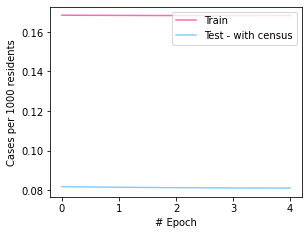

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import os
f = plt.figure(figsize=(4.5, 3.5))

#plt.axhline(y=0.051, color='r', linestyle='--', label="Naive_train")
#plt.axhline(y=0.23, color='r', linestyle='--', label="Naive_test")
plt.plot(train_accuracies, label="Train", color='hotpink')
plt.plot(test_accuracies, label="Test - with census", color='lightskyblue')
#plt.plot(test_accuracies_test, label="Test - without census", color='hotpink')

plt.xlabel("# Epoch")
plt.ylabel("Cases per 1000 residents")
plt.legend(loc='upper right')
plt.draw()

#os.chdir('/home/mxenoc/workspace/covid-CA-forecasting/plots')
#plt.savefig('test_curve.png', dpi=500, bbox_inches='tight')